In [19]:
import pandas as pd
import numpy as np
from scipy import stats
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Database credentials
db_username = 'postgres'
db_password = 'postgres'
db_host = 'localhost'
db_port = '5436'
db_name = 'experiments'
table_name = 'dbt_runs'

# Create a connection string
connection_string = f'postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}'

# Create a database engine
engine = create_engine(connection_string)

In [21]:
df = pd.read_sql_table(table_name, engine)

In [22]:
# Keep only results for setup to investigate
df = df.loc[df['experiment_setup'] == 'A']

In [23]:
df

,invocation_id,limit_fraction,limit_vars,dag,total_runtime,logs,type,experiment_setup
14,41e41373-e7f1-418f-b535-7749eac63869,0.500,"{'stg_appearances': 15011136, 'stg_game_events...",My_Own_110,7318.519620,[0m22:10:46 Running with dbt=1.7.10\n[0m22:...,all_views,A
18,8ff87be2-71fc-4be8-acdc-2964675d1681,0.500,"{'stg_appearances': 15011136, 'stg_game_events...",My_Own_110,4018.468508,[0m22:52:02 Running with dbt=1.7.10\n[0m22:...,with_materialization,A
19,ba346865-194d-4b5f-871d-2dc751a53e09,0.500,"{'stg_lineups': 15011136, 'stg_games': 536112,...",My_Own_011,223.297981,[0m01:05:41 Running with dbt=1.7.10\n[0m01:...,all_views,A
39,8fc1324a-53c9-426c-8b1d-418b3d851d0e,0.050,"{'stg_appearances': 1501114, 'stg_game_events'...",My_Own_110,394.343477,[0m23:25:27 Running with dbt=1.7.10\n[0m23:...,all_views,A
40,a55f8397-8624-409d-a1b6-7734d4aefbb4,0.005,"{'stg_drivers': 100, 'stg_lap_times': 204034, ...",My_Own_010,66.725110,[0m21:03:15 Running with dbt=1.7.10\n[0m21:...,with_materialization,A
...,...,...,...,...,...,...,...,...
8037,ee739020-c1d7-42b9-9511-27b01ac80cdf,0.005,"{'stg_lineups': 150112, 'stg_games': 5362, 'st...",My_Own_111,460.825735,[0m06:52:27 Running with dbt=1.7.10\n[0m06:...,with_materialization,A
8038,dbe24131-9fe1-4f59-a033-da52dd212129,1.000,"{'stg_constructor_results': 474510, 'stg_const...",My_Own_001,111.573433,[0m06:54:30 Running with dbt=1.7.10\n[0m06:...,all_views,A
8039,30a1ef71-38ba-430b-8db0-f2ad341518f2,1.000,"{'stg_constructor_results': 474510, 'stg_const...",My_Own_001,110.787106,[0m06:55:47 Running with dbt=1.7.10\n[0m06:...,with_materialization,A
8040,f7a831ab-059a-4189-b1c4-acebb8a6f452,0.005,"{'stg_lineups': 150112, 'stg_games': 5362, 'st...",My_Own_111,472.424132,[0m06:57:02 Running with dbt=1.7.10\n[0m06:...,all_views,A


<Figure size 2400x1000 with 0 Axes>

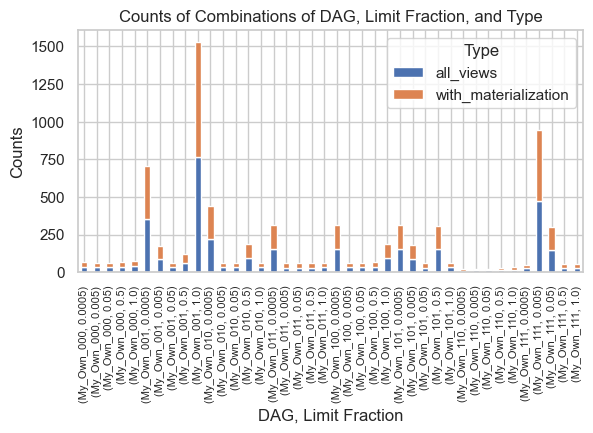

In [24]:
# Group by 'dag', 'limit_fraction', and 'type' and count the number of rows in each group
grouped_counts = df.groupby(['dag', 'limit_fraction', 'type']).size().reset_index(name='counts')

# Create a full cartesian product of 'dag', 'limit_fraction', and 'type' to ensure all combinations are represented
all_dags = df['dag'].unique()
all_limit_fractions = df['limit_fraction'].unique()
all_types = df['type'].unique()

# Using multiindex to create all possible combinations
all_combinations = pd.MultiIndex.from_product([all_dags, all_limit_fractions, all_types], names=['dag', 'limit_fraction', 'type'])
all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()

# Merge the full combination dataframe with the counts
full_data = all_combinations_df.merge(grouped_counts, on=['dag', 'limit_fraction', 'type'], how='left').fillna(0)

# Pivot the data for better visualization
pivot_data = full_data.pivot_table(index=['dag', 'limit_fraction'], columns='type', values='counts', fill_value=0)

# Create the bar chart
sns.set(style="whitegrid")

plt.figure(figsize=(24,10))
pivot_data.plot(kind='bar', stacked=True)
plt.title('Counts of Combinations of DAG, Limit Fraction, and Type')
plt.ylabel('Counts')
plt.xlabel('DAG, Limit Fraction')
plt.legend(title='Type')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout(pad=2)
plt.show()

In [25]:
sorted_full_data = full_data.sort_values(by='counts', ascending=True)
sorted_full_data

,dag,limit_fraction,type,counts
9,My_Own_110,0.0005,with_materialization,11
8,My_Own_110,0.0005,all_views,11
1,My_Own_110,0.5000,with_materialization,12
2,My_Own_110,0.0500,all_views,12
5,My_Own_110,0.0050,with_materialization,12
...,...,...,...,...
68,My_Own_001,0.0005,all_views,354
45,My_Own_111,0.0050,with_materialization,472
44,My_Own_111,0.0050,all_views,472
67,My_Own_001,1.0000,with_materialization,765


In [26]:
def get_plot_one_dag(dag_name, ax):
    # Filter the dataframe for the current 'dag'
    dag_df = df[df['dag'] == dag_name]
    
    # Group by 'limit_fraction' and 'type' and calculate the mean of 'total_runtime'
    avg_runtime_dag = dag_df.groupby(['limit_fraction', 'type'])['total_runtime'].mean().unstack()
    
    # Plot the data
    avg_runtime_dag.plot(kind='bar', ax=ax)
    ax.set_title(f'DAG: {dag_name}')
    ax.set_xlabel('Limit Fraction')
    ax.set_ylabel('Average Total Runtime (s)')
    ax.legend(title='Type')

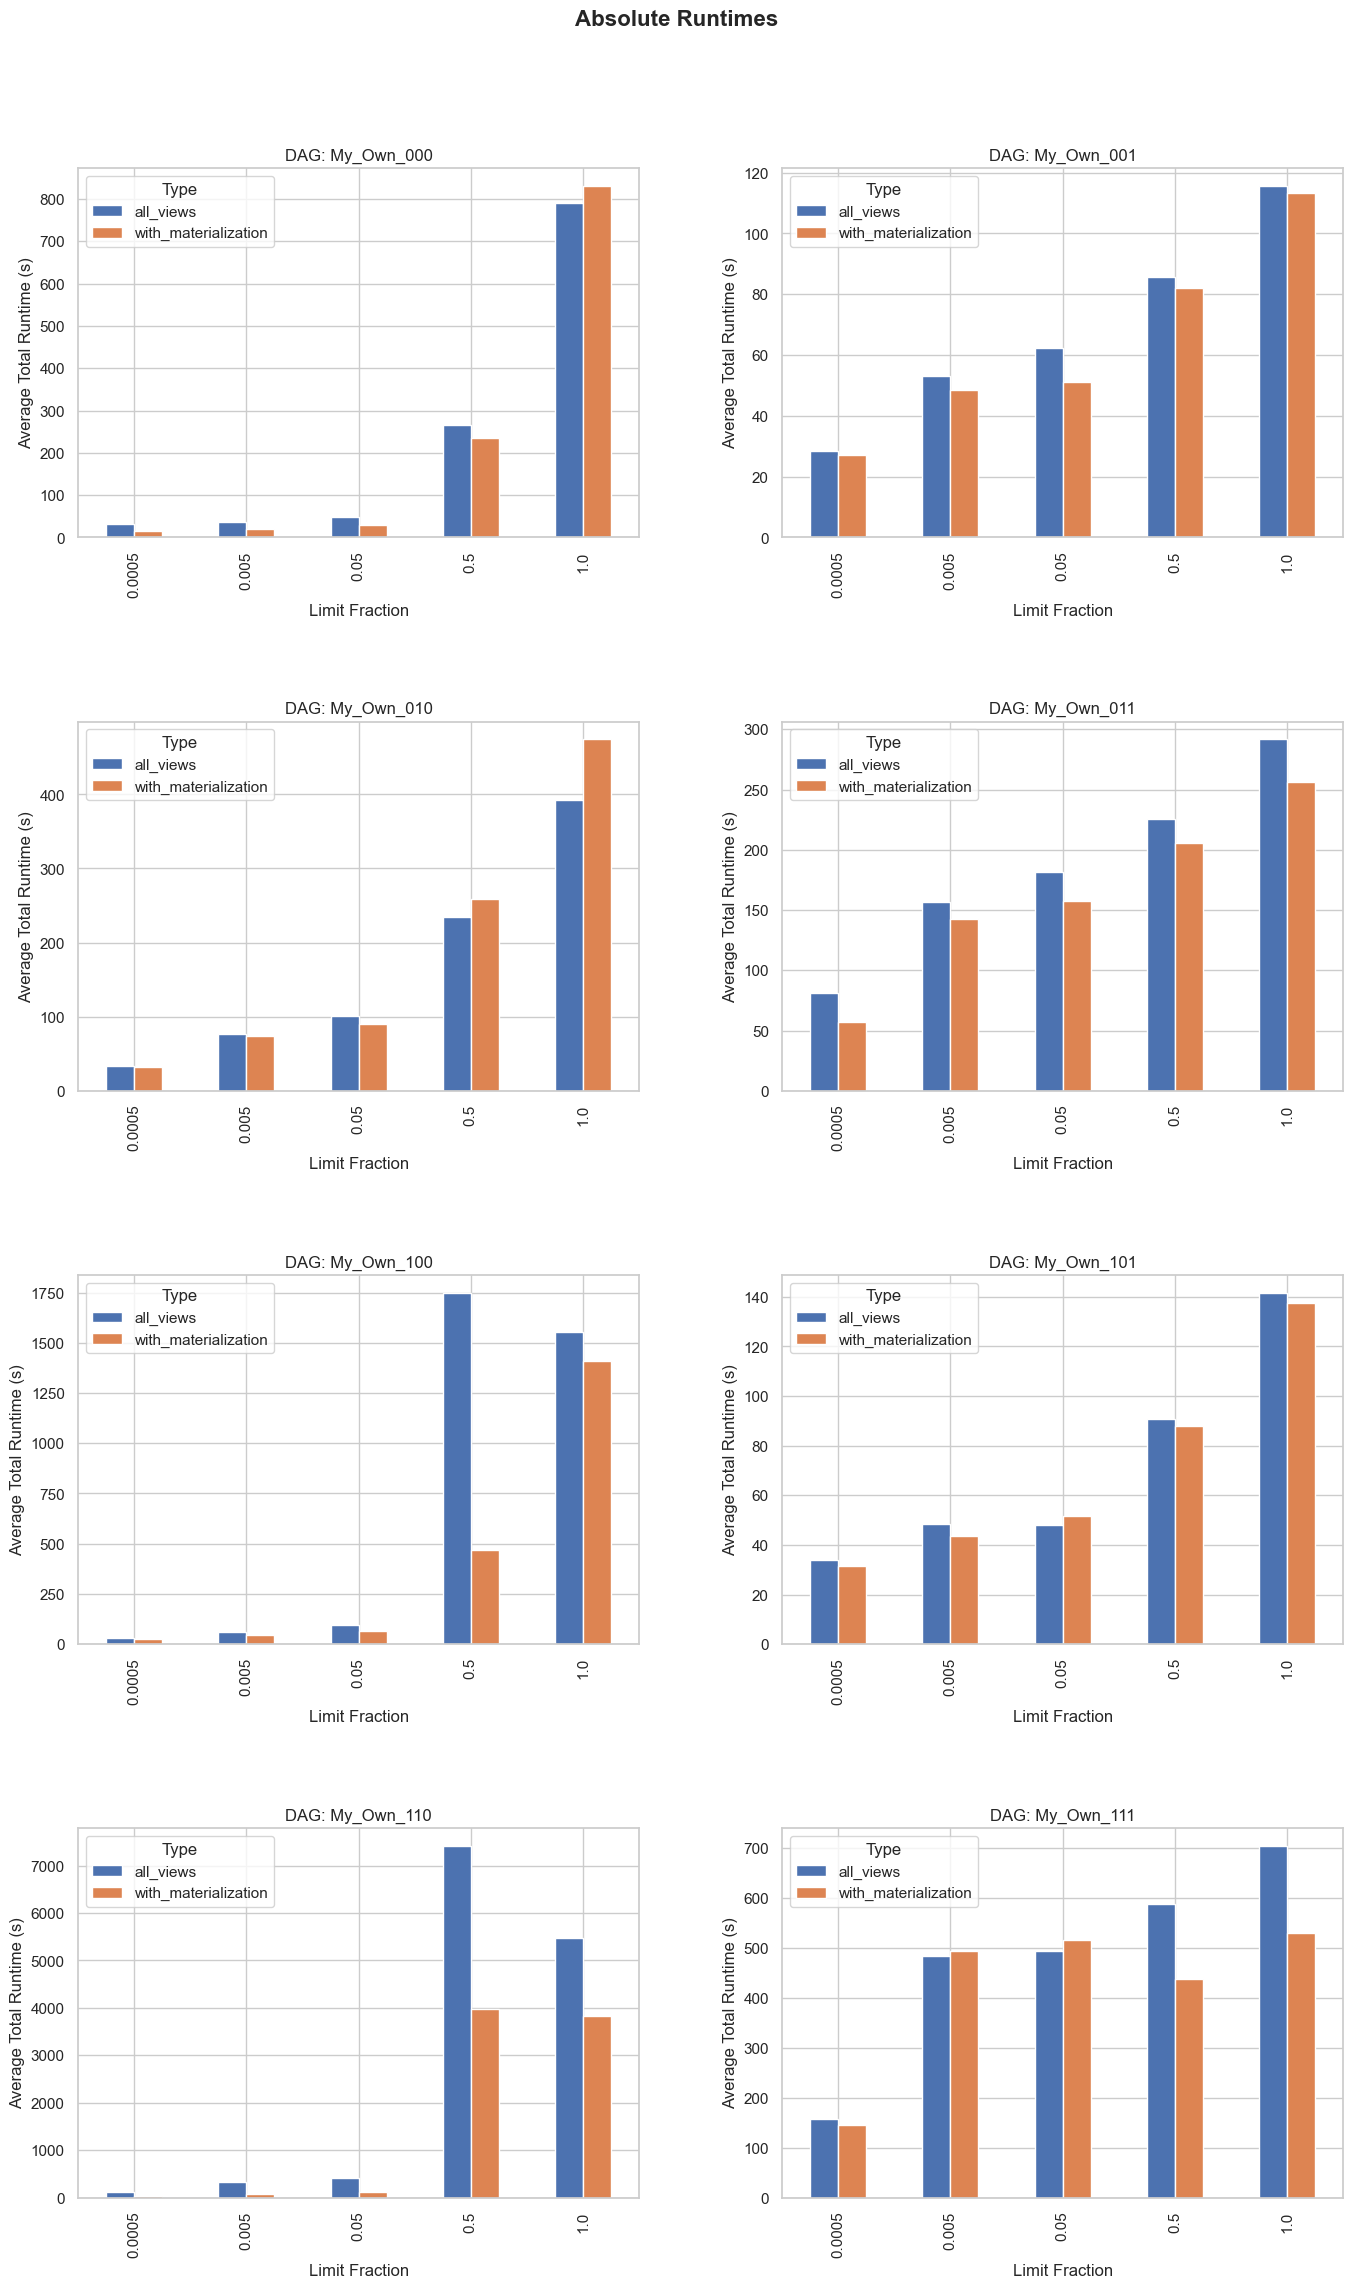

In [27]:
def create_all_dags_plot():
    unique_dags = sorted(df['dag'].unique())
    num_dags = len(unique_dags)
    
    # Determine the grid size for subplots
    cols = 2  # You can adjust this to change the number of columns
    rows = (num_dags + cols - 1) // cols  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
    axes = axes.flatten()  # Flatten axes array for easy iteration
    
    for i, dag in enumerate(unique_dags):
        get_plot_one_dag(dag, axes[i])
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Add a title to the entire figure
    fig.suptitle('Absolute Runtimes', fontsize=16, weight='bold')
    
    plt.tight_layout(pad=5)
    plt.show()

# Call the function to create the plot
create_all_dags_plot()


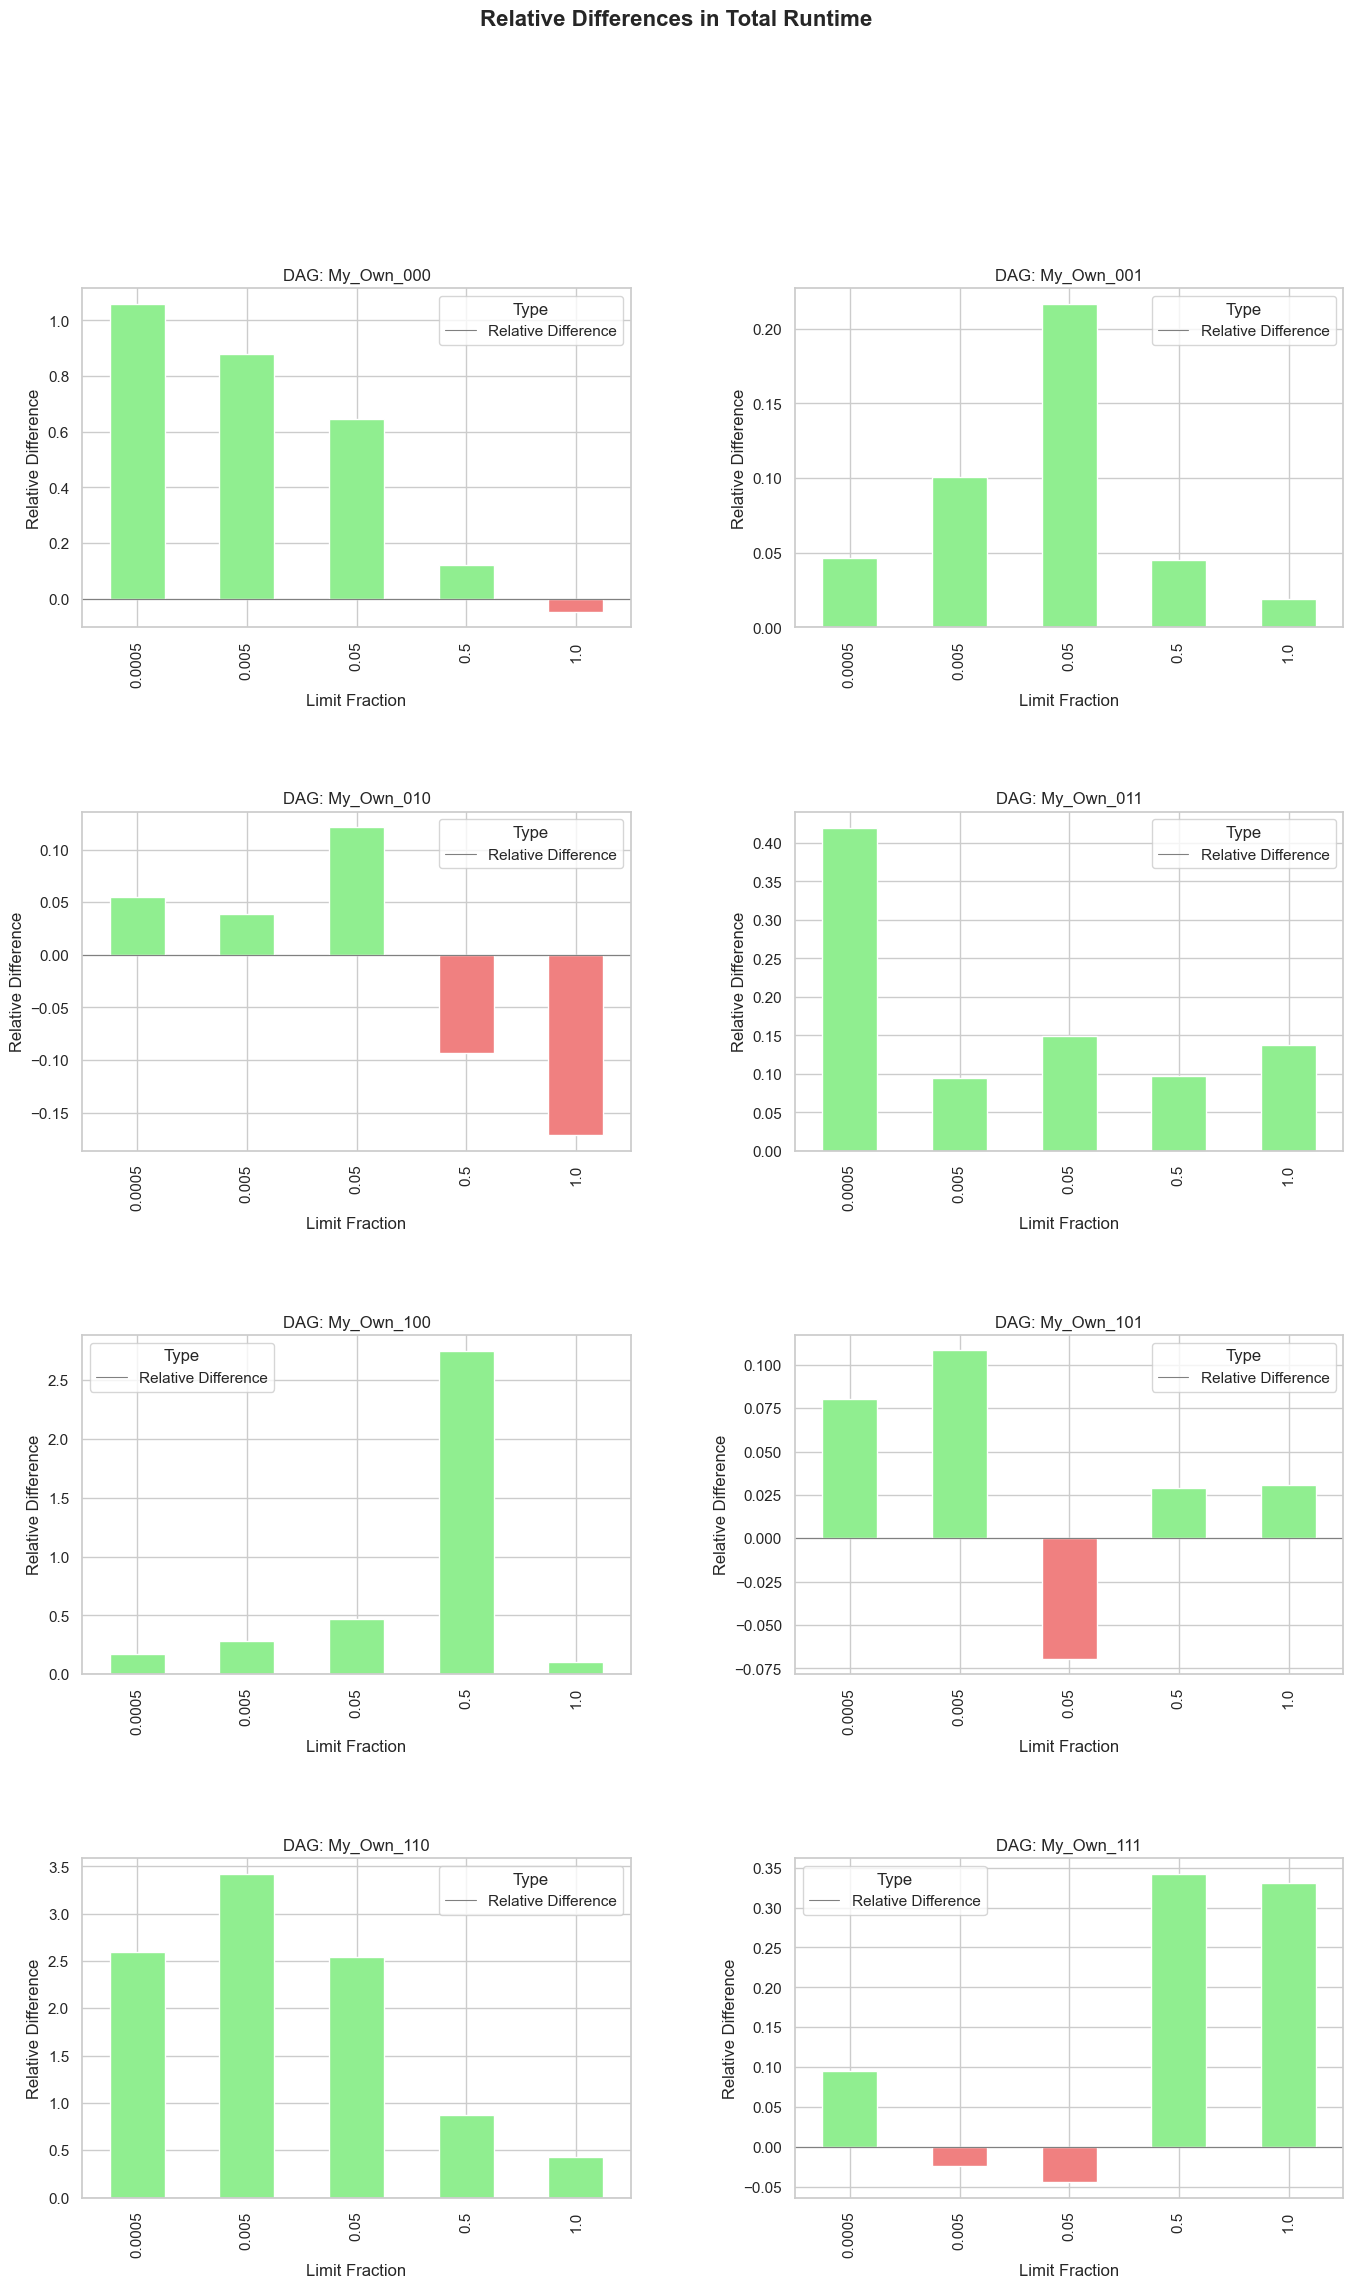

In [28]:
def get_plot_one_dag(dag_name, ax):
    # Filter the dataframe for the current 'dag'
    dag_df = df[df['dag'] == dag_name]
    
    # Group by 'limit_fraction' and 'type' and calculate the mean of 'total_runtime'
    avg_runtime_dag = dag_df.groupby(['limit_fraction', 'type'])['total_runtime'].mean().unstack()
    
    # Calculate the relative difference between 'all_views' and 'with_materialization'
    relative_diff = (avg_runtime_dag['all_views'] - avg_runtime_dag['with_materialization']) / avg_runtime_dag['with_materialization']
    
    # Plot the relative differences with custom colors for positive and negative bars
    colors = ['lightgreen' if val > 0 else 'lightcoral' for val in relative_diff]
    relative_diff.plot(kind='bar', ax=ax, color=colors)
    
    ax.set_title(f'DAG: {dag_name}')
    ax.set_xlabel('Limit Fraction')
    ax.set_ylabel('Relative Difference')
    ax.axhline(0, color='gray', linewidth=0.8)  # Add a horizontal line at y=0 for reference
    ax.legend(['Relative Difference'], title='Type')

def create_all_dags_plot():
    unique_dags = sorted(df['dag'].unique())
    num_dags = len(unique_dags)
    
    # Determine the grid size for subplots
    cols = 2  # You can adjust this to change the number of columns
    rows = (num_dags + cols - 1) // cols  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
    axes = axes.flatten()  # Flatten axes array for easy iteration
    
    for i, dag in enumerate(unique_dags):
        get_plot_one_dag(dag, axes[i])
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Add a title to the entire figure
    fig.suptitle('Relative Differences in Total Runtime', fontsize=16, weight='bold')
    
    plt.tight_layout(pad=5, rect=[0, 0, 1, 0.95])  # Adjust rect to make space for the suptitle
    plt.show()

# Call the function to create the plot
create_all_dags_plot()


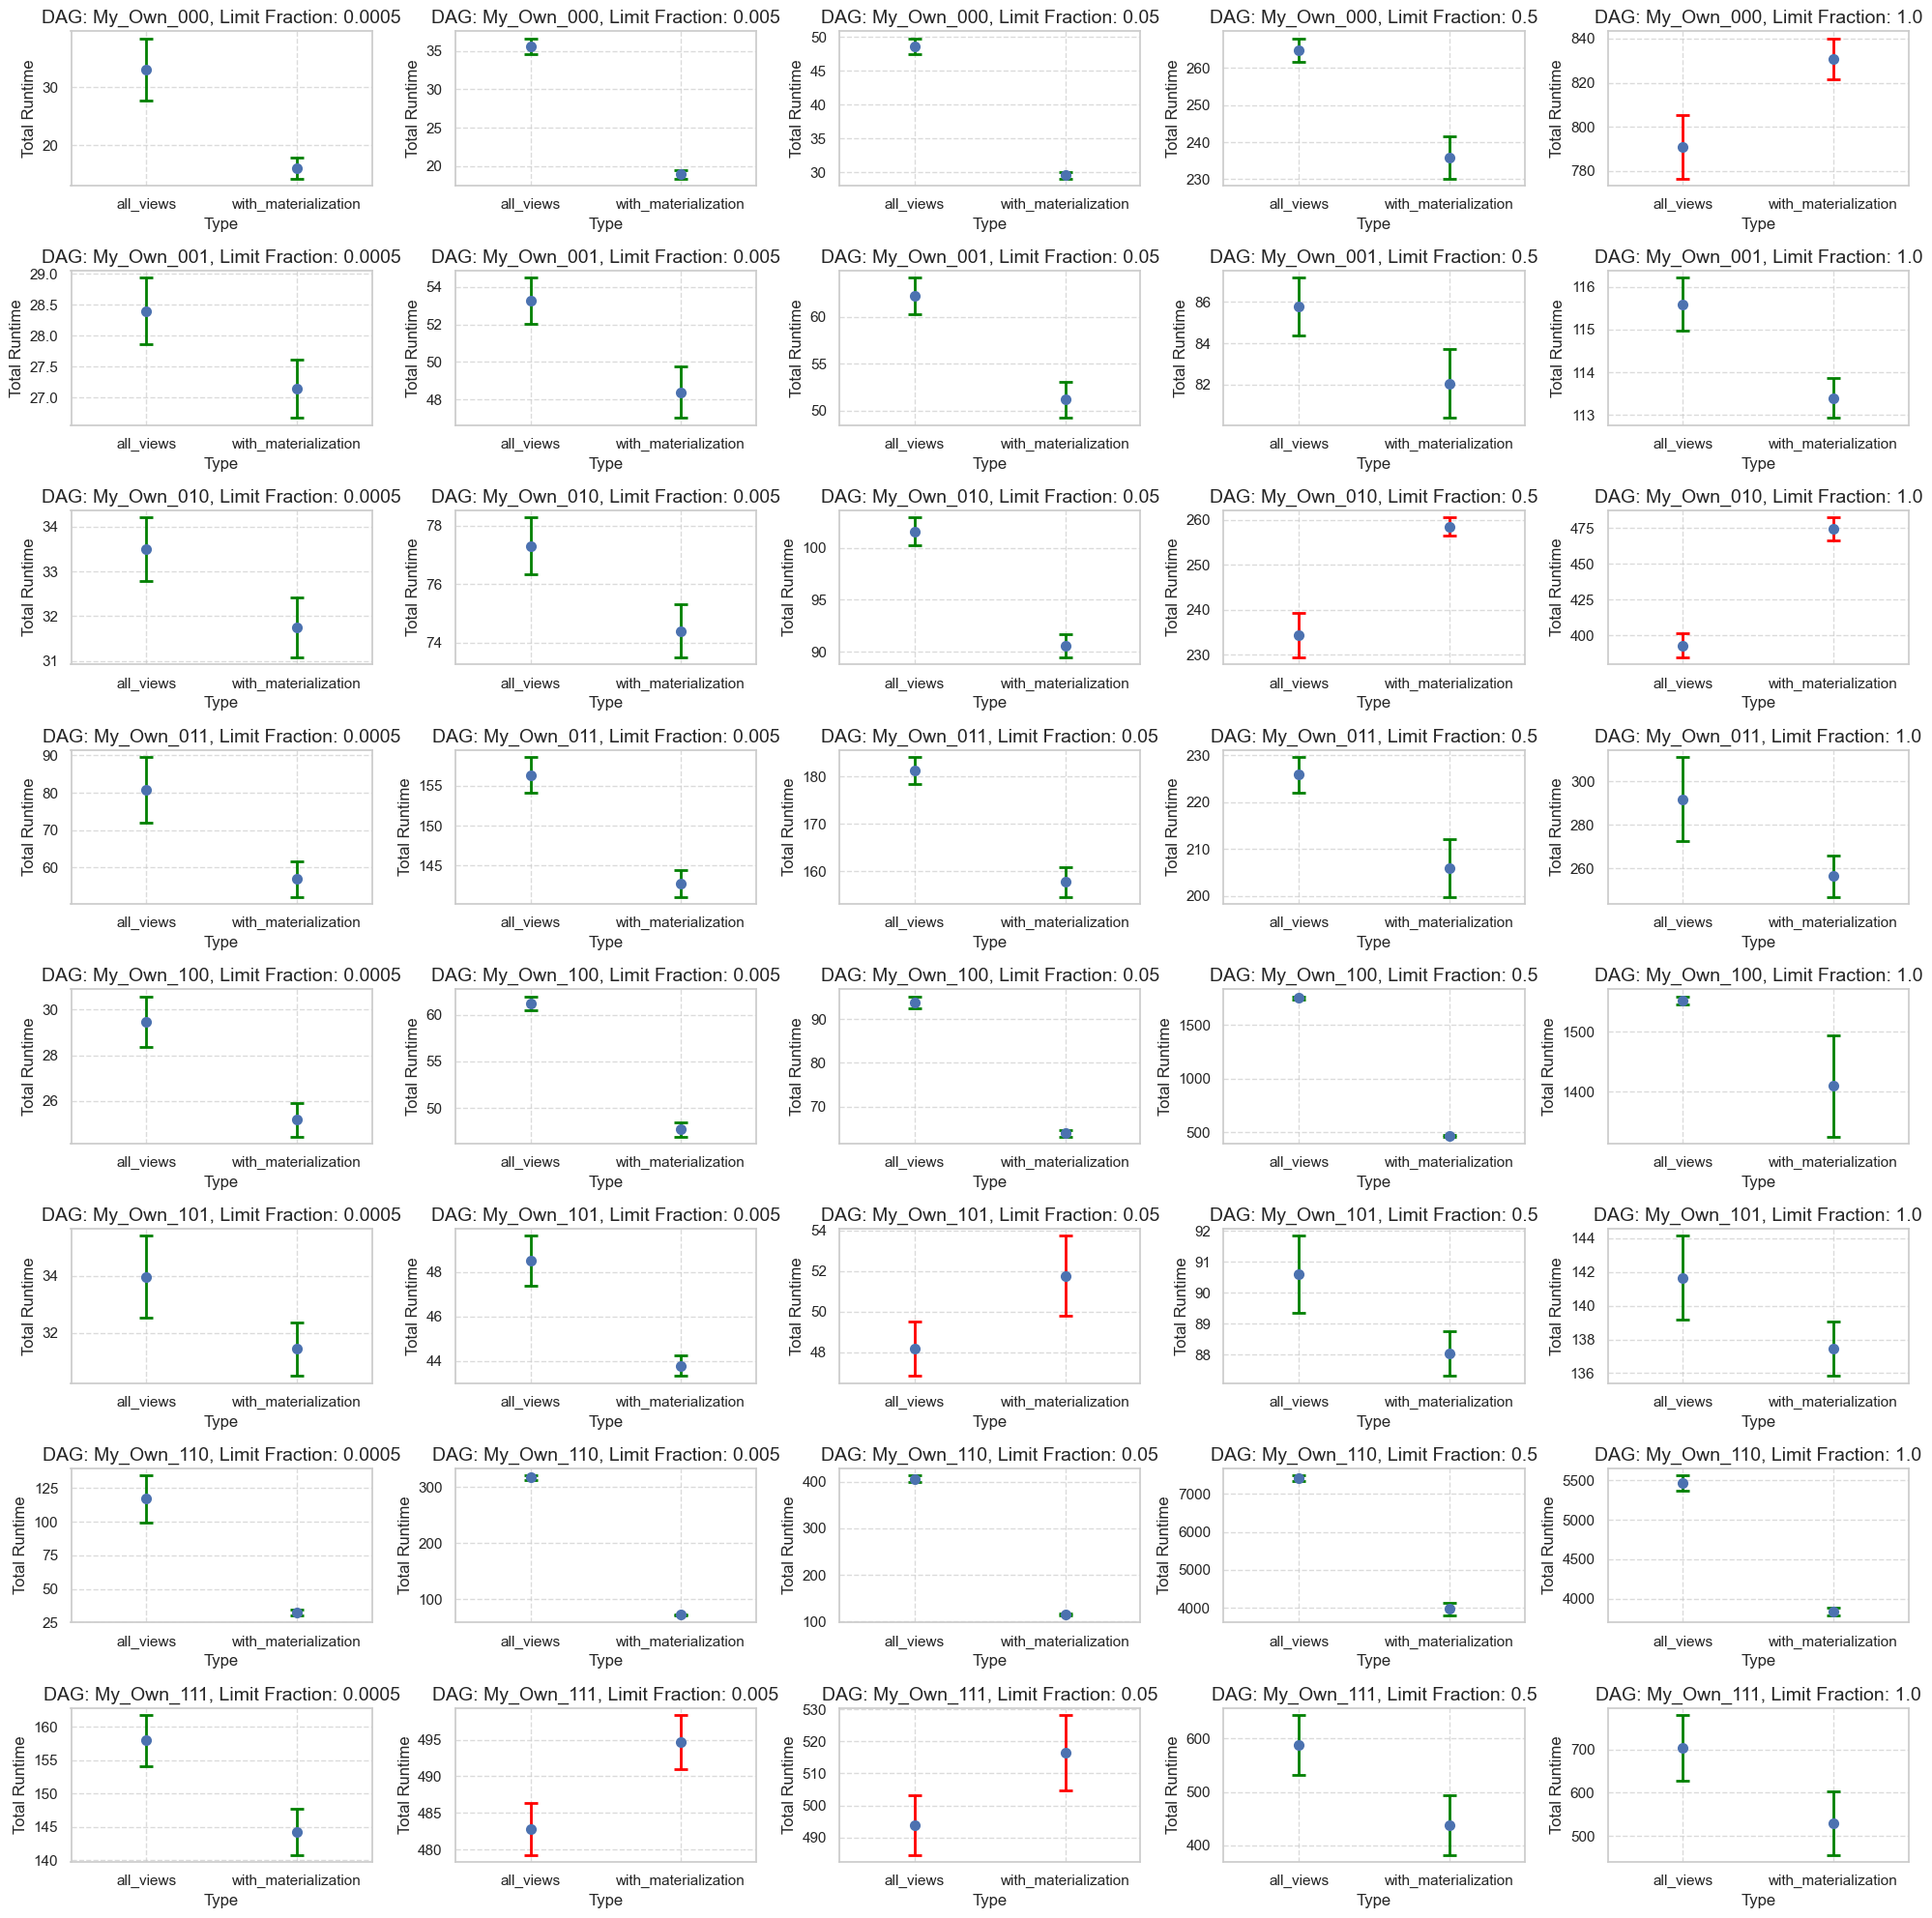

In [29]:
def get_ci_plot_one_dag(dag_name, limit_fraction, ax):
    # Filter the dataframe for the current 'dag'
    dag_df = df[(df['dag'] == dag_name) & (df['limit_fraction'] == limit_fraction)]
    
    # Filter necessary columns
    data_filtered = dag_df[['type', 'total_runtime']]
    
    # Group by 'type' and calculate mean and 95% CI for total_runtime
    grouped = data_filtered.groupby('type').agg(
        total_runtime_mean=('total_runtime', 'mean'),
        total_runtime_count=('total_runtime', 'count'),
        total_runtime_std=('total_runtime', 'std')
    ).reset_index()
    
    # Calculate 95% CI
    confidence_level = 0.95
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    grouped['ci'] = z_score * grouped['total_runtime_std'] / np.sqrt(grouped['total_runtime_count'])
    
    # Determine CI color based on the conditions
    all_views_ci = grouped.loc[grouped['type'] == 'all_views', ['total_runtime_mean', 'ci']].values[0]
    with_materialization_ci = grouped.loc[grouped['type'] == 'with_materialization', ['total_runtime_mean', 'ci']].values[0]
    
    if all_views_ci[0] - all_views_ci[1] > with_materialization_ci[0] + with_materialization_ci[1]:
        ci_color = 'green'
    elif all_views_ci[0] + all_views_ci[1] < with_materialization_ci[0] - with_materialization_ci[1]:
        ci_color = 'red'
    else:
        ci_color = 'blue'
    
    # Creating a scatter plot with error bars
    ax.errorbar(grouped['type'], grouped['total_runtime_mean'], yerr=grouped['ci'], fmt='o', ecolor=ci_color, capsize=5, elinewidth=2, markeredgewidth=2)
    
    # Adding labels and title to match the format
    ax.set_xlabel('Type', fontsize=12)
    ax.set_ylabel('Total Runtime', fontsize=12)
    ax.set_title(f'DAG: {dag_name}, Limit Fraction: {limit_fraction}', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust x-axis limits to bring the points closer together
    ax.set_xlim(-0.5, 1.5)

def plot_all_combinations():
    unique_dags = sorted(df['dag'].unique())
    unique_limit_fractions = sorted(df['limit_fraction'].unique())
    
    fig, axs = plt.subplots(len(unique_dags), len(unique_limit_fractions), figsize=(20, 20))
    
    for i, dag in enumerate(unique_dags):
        for j, limit_fraction in enumerate(unique_limit_fractions):
            get_ci_plot_one_dag(dag, limit_fraction, axs[i, j])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example usage to create the big plot with many subplots
plot_all_combinations()


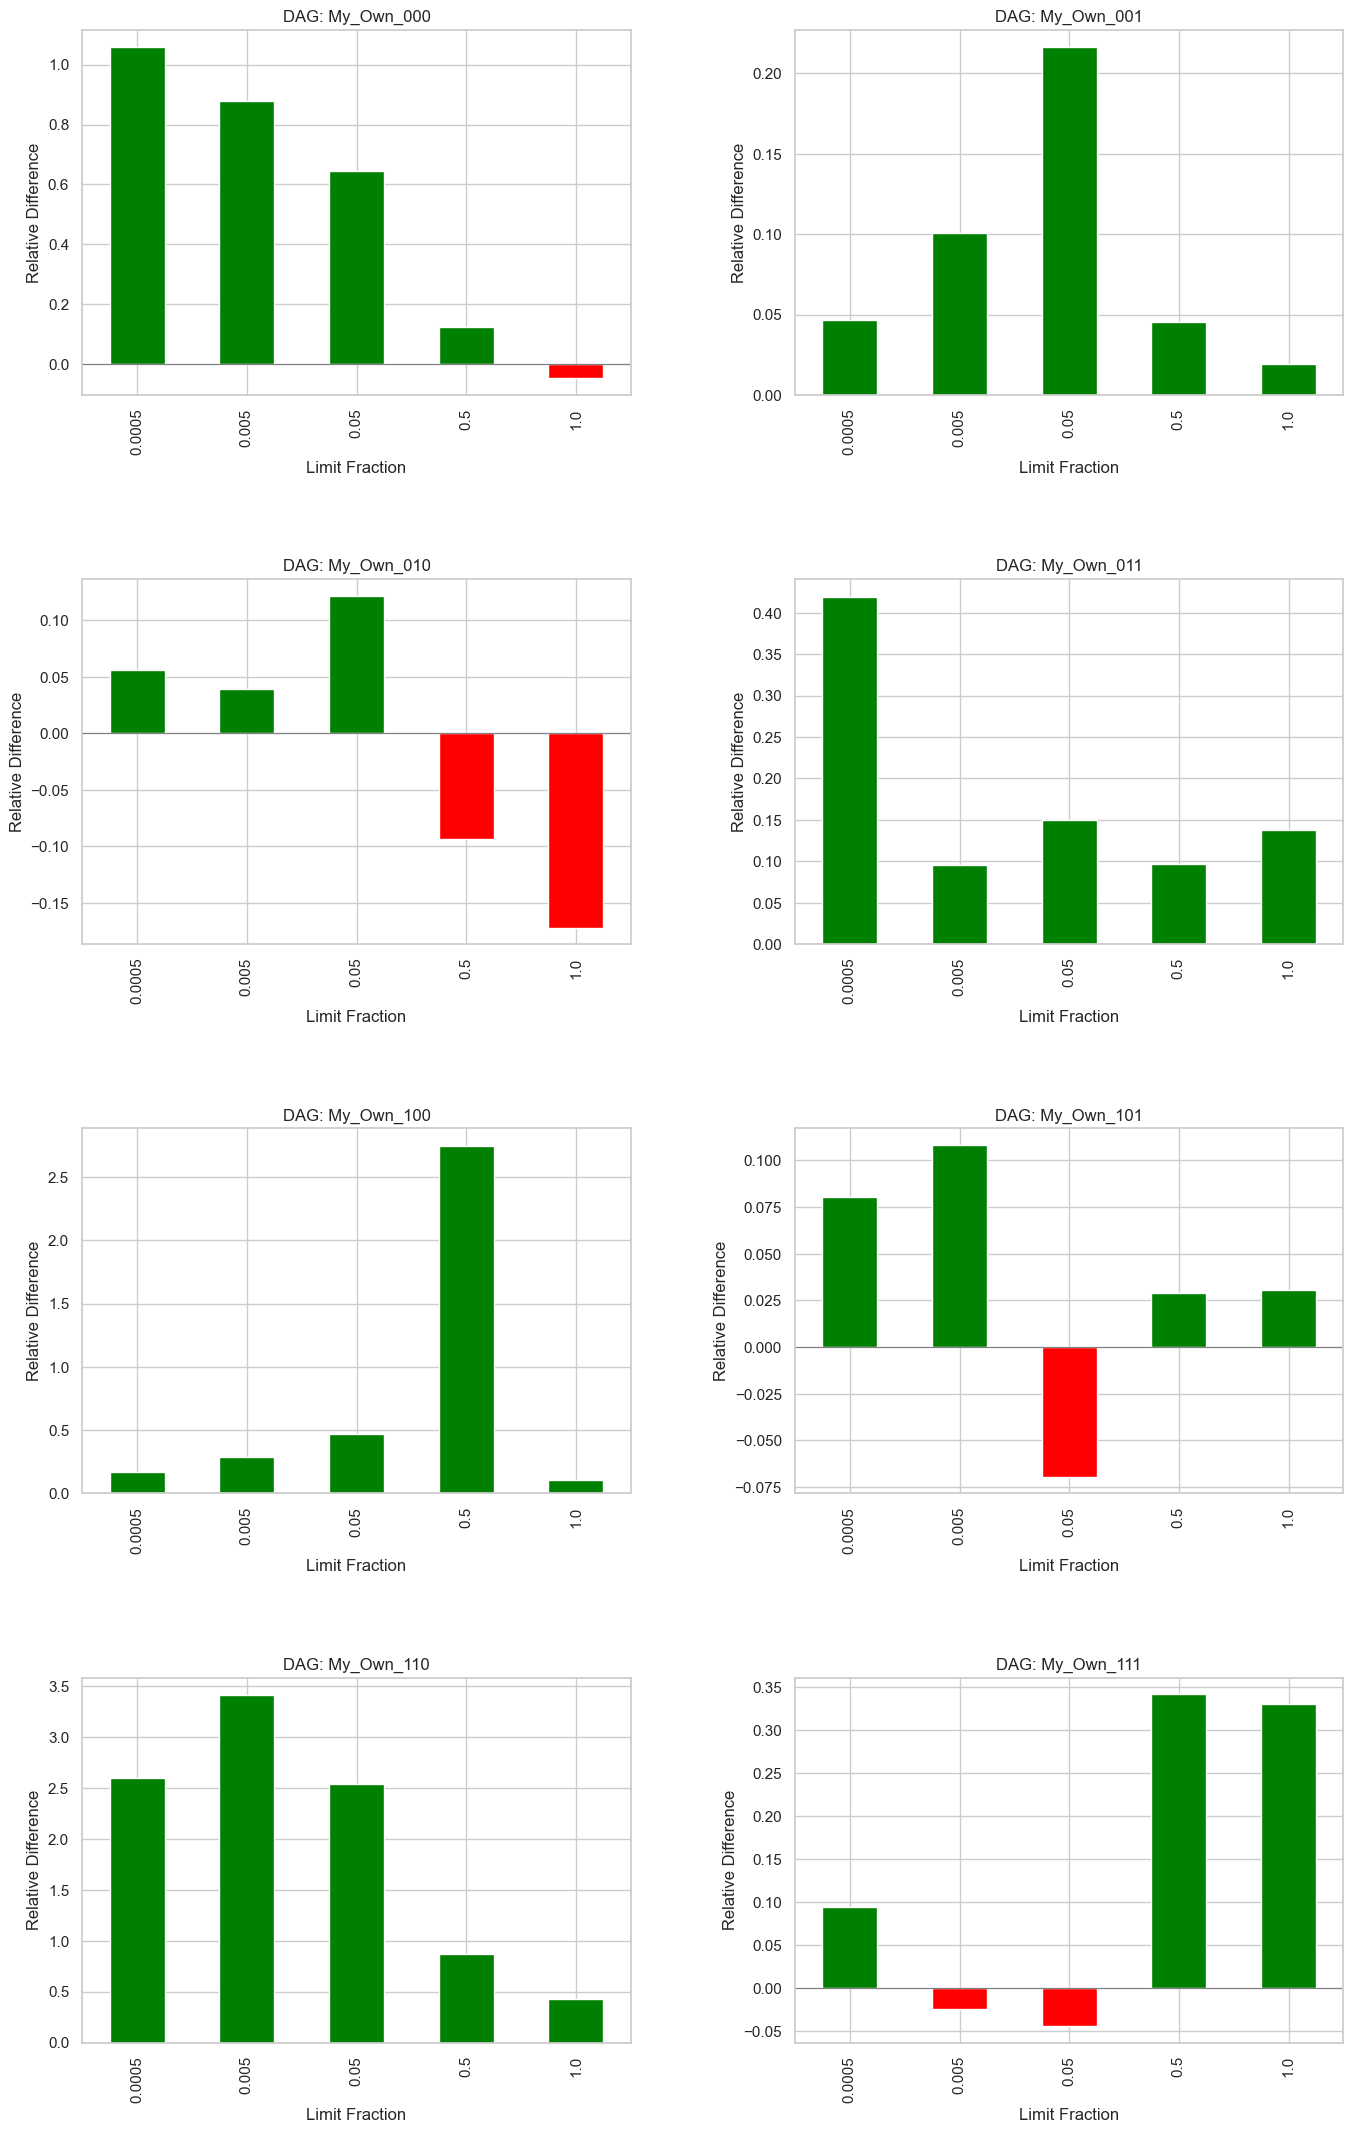

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


def get_ci_color(dag_name, limit_fraction):
    # Filter the dataframe for the current 'dag' and 'limit_fraction'
    dag_df = df[(df['dag'] == dag_name) & (df['limit_fraction'] == limit_fraction)]
    
    # Filter necessary columns
    data_filtered = dag_df[['type', 'total_runtime']]
    
    # Group by 'type' and calculate mean and 95% CI for total_runtime
    grouped = data_filtered.groupby('type').agg(
        total_runtime_mean=('total_runtime', 'mean'),
        total_runtime_count=('total_runtime', 'count'),
        total_runtime_std=('total_runtime', 'std')
    ).reset_index()
    
    # Calculate 95% CI
    confidence_level = 0.95
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    grouped['ci'] = z_score * grouped['total_runtime_std'] / np.sqrt(grouped['total_runtime_count'])
    
    # Determine CI color based on the conditions
    all_views_ci = grouped.loc[grouped['type'] == 'all_views', ['total_runtime_mean', 'ci']].values[0]
    with_materialization_ci = grouped.loc[grouped['type'] == 'with_materialization', ['total_runtime_mean', 'ci']].values[0]
    
    if all_views_ci[0] - all_views_ci[1] > with_materialization_ci[0] + with_materialization_ci[1]:
        return 'green'
    elif all_views_ci[0] + all_views_ci[1] < with_materialization_ci[0] - with_materialization_ci[1]:
        return 'red'
    else:
        return 'blue'

def get_plot_one_dag(dag_name, ax):
    # Filter the dataframe for the current 'dag'
    dag_df = df[df['dag'] == dag_name]
    
    # Group by 'limit_fraction' and 'type' and calculate the mean of 'total_runtime'
    avg_runtime_dag = dag_df.groupby(['limit_fraction', 'type'])['total_runtime'].mean().unstack()
    
    # Calculate the relative difference between 'all_views' and 'with_materialization'
    relative_diff = (avg_runtime_dag['all_views'] - avg_runtime_dag['with_materialization']) / avg_runtime_dag['with_materialization']
    
    # Determine the colors based on CI
    colors = [get_ci_color(dag_name, lf) for lf in relative_diff.index]
    
    # Plot the relative differences with custom colors for positive and negative bars
    relative_diff.plot(kind='bar', ax=ax, color=colors)
    
    ax.set_title(f'DAG: {dag_name}')
    ax.set_xlabel('Limit Fraction')
    ax.set_ylabel('Relative Difference')
    ax.axhline(0, color='gray', linewidth=0.8)  # Add a horizontal line at y=0 for reference
    # ax.legend(['Relative Difference'], title='Type')

def create_all_dags_plot():
    unique_dags = sorted(df['dag'].unique())
    num_dags = len(unique_dags)
    
    # Determine the grid size for subplots
    cols = 2  # You can adjust this to change the number of columns
    rows = (num_dags + cols - 1) // cols  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
    axes = axes.flatten()  # Flatten axes array for easy iteration
    
    for i, dag in enumerate(unique_dags):
        get_plot_one_dag(dag, axes[i])
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Add a title to the entire figure
    # fig.suptitle('Relative Differences in Total Runtime', fontsize=16, weight='bold')
    
    plt.tight_layout(pad=5, rect=[0, 0, 1, 0.95])  # Adjust rect to make space for the subtitle
    plt.show()

# Call the function to create the plot
create_all_dags_plot()


In [31]:
def get_table_form(dag_name, limit_fraction):
    # Filter the dataframe for the current 'dag' and 'limit_fraction'
    dag_df = df[(df['dag'] == dag_name) & (df['limit_fraction'] == limit_fraction)]
    
    # Filter necessary columns
    data_filtered = dag_df[['type', 'total_runtime']]
    
    # Group by 'type' and calculate mean and 95% CI for total_runtime
    grouped = data_filtered.groupby('type').agg(
        total_runtime_mean=('total_runtime', 'mean'),
        total_runtime_count=('total_runtime', 'count'),
        total_runtime_std=('total_runtime', 'std')
    ).reset_index()
    
    # Calculate 95% CI
    confidence_level = 0.95
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    grouped['ci'] = z_score * grouped['total_runtime_std'] / np.sqrt(grouped['total_runtime_count'])
    
    # Determine CI color based on the conditions
    all_views_ci = grouped.loc[grouped['type'] == 'all_views', ['total_runtime_mean', 'ci']].values[0]
    with_materialization_ci = grouped.loc[grouped['type'] == 'with_materialization', ['total_runtime_mean', 'ci']].values[0]
    
    return all_views_ci, with_materialization_ci

In [32]:
def calc_final_output(df_):
    data = []
    unique_dags = sorted(df['dag'].unique())
    unique_limit_fractions = sorted(df['limit_fraction'].unique())
    for dag in unique_dags:
        for lf in unique_limit_fractions:
            view_ci, mater_ci = get_table_form(dag, lf)
            data.append([dag, lf, view_ci, mater_ci])
    
    # Convert to DataFrame
    df_ = pd.DataFrame(data, columns=["dag", "limit_fraction", "view_ci", "mater_ci"])
    
    def calculate_bounds(ci):
        mean, error = ci
        lower_bound = mean - error
        upper_bound = mean + error
        return lower_bound, upper_bound
    
    def check_overlap(ci1, ci2):
        lb1, ub1 = calculate_bounds(ci1)
        lb2, ub2 = calculate_bounds(ci2)
        return not (ub1 < lb2 or ub2 < lb1)
    
    results = []
    
    for _, row in df_.iterrows():
        dag = row["dag"]
        limit_fraction = row["limit_fraction"]
        view_ci = row["view_ci"]
        mater_ci = row["mater_ci"]
        
        # Calculate bounds for both CIs
        view_lb, view_ub = calculate_bounds(view_ci)
        mater_lb, mater_ub = calculate_bounds(mater_ci)
        
        # Check overlap
        overlap = check_overlap(view_ci, mater_ci)
        
        view_mean = (view_ub + view_lb) / 2
        mater_mean = (mater_lb + mater_ub) / 2
        
        results.append([dag, limit_fraction, view_mean, view_ci, view_lb, view_ub, mater_ci, mater_mean, mater_lb, mater_ub, overlap])
    
    # Create a DataFrame with results
    return pd.DataFrame(results, columns=[
        "dag", "limit_fraction", 'view_mean', "view_ci", "view_lb", "view_ub", "mater_ci",'mater_mean', "mater_lb", "mater_ub", "overlap"
    ])

In [33]:
resulting_df = calc_final_output(df_=df)
resulting_df['relative_difference'] = (resulting_df['view_mean'] - resulting_df['mater_mean']) / resulting_df['mater_mean']
resulting_df[['dag', 'limit_fraction', 'view_mean', 'view_lb', 'view_ub', 'mater_mean', 'mater_lb', 'mater_ub', 'relative_difference']]

,dag,limit_fraction,view_mean,view_lb,view_ub,mater_mean,mater_lb,mater_ub,relative_difference
0,My_Own_000,0.0005,33.079922,27.659437,38.500407,16.056728,14.207172,17.906284,1.060191
1,My_Own_000,0.0050,35.581972,34.529958,36.633987,18.927747,18.396458,19.459035,0.879884
2,My_Own_000,0.0500,48.652894,47.503020,49.802769,29.576588,29.074540,30.078635,0.644980
3,My_Own_000,0.5000,264.739776,261.512961,267.966592,235.903465,230.228370,241.578560,0.122238
4,My_Own_000,1.0000,791.062321,776.662905,805.461738,830.862193,821.548774,840.175611,-0.047902
5,My_Own_001,0.0005,28.396909,27.859019,28.934799,27.137577,26.666557,27.608596,0.046405
6,My_Own_001,0.0050,53.254841,52.026118,54.483565,48.374121,47.008073,49.740170,0.100895
7,My_Own_001,0.0500,62.209091,60.249838,64.168343,51.151492,49.203843,53.099141,0.216174
8,My_Own_001,0.5000,85.770254,84.378178,87.162329,82.054799,80.395488,83.714110,0.045280
9,My_Own_001,1.0000,115.594457,114.979086,116.209827,113.395444,112.930599,113.860289,0.019392


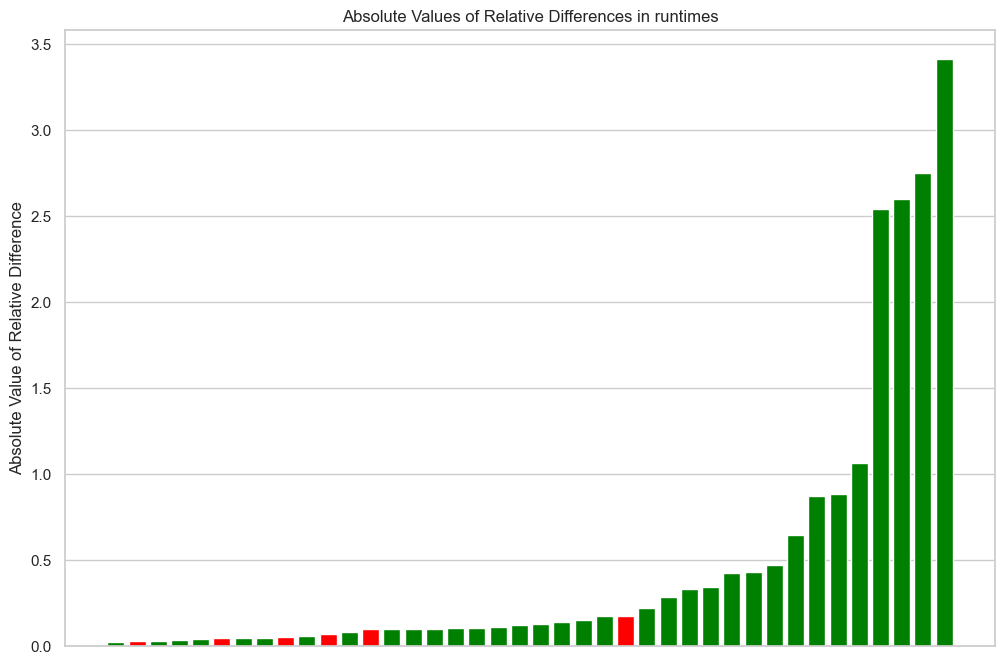

In [34]:
data = resulting_df

# Process the data
data['absolute_relative_difference'] = data['relative_difference'].abs()
data['color'] = data['relative_difference'].apply(lambda x: 'green' if x > 0 else 'red')

# Sort the data by absolute_relative_difference
data_sorted = data.sort_values(by='absolute_relative_difference')

# Create the bar chart with sorted data
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(data_sorted)), data_sorted['absolute_relative_difference'], color=data_sorted['color'])

# Add labels and title
plt.xlabel('')
plt.ylabel('Absolute Value of Relative Difference')
plt.title('Absolute Values of Relative Differences in runtimes')
plt.xticks([])

# Display the chart
plt.show()